In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
#split into train and test
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    confusion_matrix,
    classification_report
)

# ann and dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import tensorflow as tf
import random as rn

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.autolayout"] = True

In [2]:
accident_data = pd.read_csv('accident_data.csv',encoding = "ISO-8859-1").sort_values(by='Accident_Index')
accident_data.head()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
27261,2.00503E+12,A,591.0,NaN,0.0,Slight,None,08/04/2005,Friday,1.0,...,Cumbria,Dry,Single carriageway,None,60,16:39,Rural,Fine no high winds,2005,No
28085,2.00503E+12,NaN,0.0,NaN,0.0,Slight,None,01/09/2005,Thursday,2.0,...,Cumbria,Dry,Single carriageway,None,60,14:15,Rural,Fine no high winds,2005,No
28084,2.00503E+12,A,6.0,A,590.0,Slight,None,18/09/2005,Sunday,1.0,...,Cumbria,Wet or damp,Single carriageway,None,60,00:20,Rural,Other,2005,No
28083,2.00503E+12,A,591.0,Unclassified,0.0,Slight,None,19/09/2005,Monday,1.0,...,Cumbria,Dry,Dual carriageway,None,70,15:50,Rural,Fine no high winds,2005,No
28082,2.00503E+12,A,69.0,NaN,0.0,Slight,None,15/09/2005,Thursday,1.0,...,Cumbria,Wet or damp,Single carriageway,None,60,09:17,Rural,Raining no high winds,2005,No


In [3]:
accident_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 27261 to 1048574
Data columns (total 34 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   Accident_Index                               1048575 non-null  object 
 1   1st_Road_Class                               742986 non-null   object 
 2   1st_Road_Number                              1048573 non-null  float64
 3   2nd_Road_Class                               608751 non-null   object 
 4   2nd_Road_Number                              1037772 non-null  float64
 5   Accident_Severity                            1048575 non-null  object 
 6   Carriageway_Hazards                          1048546 non-null  object 
 7   Date                                         1048575 non-null  object 
 8   Day_of_Week                                  1048575 non-null  object 
 9   Did_Police_Officer_Attend_Scene_of_Acciden

In [4]:
accident_data.Day_of_Week.unique()

array(['Friday', 'Thursday', 'Sunday', 'Monday', 'Wednesday', 'Saturday',
       'Tuesday'], dtype=object)

In [5]:
# Removing exact duplicates
accident_data.drop(columns=['Accident_Index'], inplace=True, axis=1)
remove_data = accident_data.duplicated(keep=False)

accident_data = accident_data[~remove_data]
print(len(accident_data))

1048537


In [6]:
accident_data.Accident_Severity.value_counts()

Slight     895845
Serious    138192
Fatal       14500
Name: Accident_Severity, dtype: int64

In [7]:
# Removing all garbage values as Nan
accident_data['Urban_or_Rural_Area'] = accident_data['Urban_or_Rural_Area'].apply(lambda x : np.nan if x == 'Unallocated' \
                                                                                  else x).copy()
accident_data['Light_Conditions'] = accident_data['Light_Conditions'].apply(lambda x :np.nan \
                                                                            if x =='Darkness - lighting unknown' \
                                                                            else x).copy()

accident_data['Junction_Control'] = accident_data['Junction_Control'].apply(lambda x :np.nan \
                                                                            if x =='Data missing or out of range' \
                                                                            else x).copy()
accident_data['Junction_Detail'] = accident_data['Junction_Detail'].apply(lambda x :np.nan \
                                                                            if x =='Data missing or out of range' \
                                                                            else x).copy()
accident_data['2nd_Road_Class'] = accident_data['2nd_Road_Class'].apply(lambda x: np.nan if x == 'Unclassified' else x)

# Correcting the misspelled words
accident_data['Junction_Control'] = accident_data['Junction_Control'].apply(lambda x :'Auto traffic signal' \
                                                                            if x =='Auto traffic sigl' \
                                                                            else x).copy()
accident_data['Special_Conditions_at_Site'] = accident_data['Special_Conditions_at_Site'].apply(lambda x :\
                                                                                                'Auto traffic signal - out' \
                                                                                                if x =='Auto traffic sigl - out' \
                                                                                                else x).copy()
accident_data['Special_Conditions_at_Site'] = accident_data['Special_Conditions_at_Site'].apply(lambda x :\
                                                                                                'Auto signal part defective' \
                                                                                                if x =='Auto sigl part defective' \
                                                                                                else x).copy()




In [8]:
accident_data.drop(columns=['Local_Authority_(District)', 'Local_Authority_(Highway)', \
                            'Location_Easting_OSGR', 'Location_Northing_OSGR', '2nd_Road_Class', \
                            '2nd_Road_Number', '1st_Road_Number', 'LSOA_of_Accident_Location', \
                            'Police_Force', 
                            'Latitude', 'Longitude'], inplace=True, axis = 1)# 'Date', 'Time', 'Year', 'Day_of_Week',\
null_data = accident_data[accident_data.isna().sum(axis=1)>=1].copy()
accident_data.drop(list(null_data.index), axis=0, inplace = True)
accident_data.shape, null_data.shape

((478581, 22), (569956, 22))

In [9]:
# Converting Date and Time column to datetime object 
#accident_data['Date'] = accident_data.Date.apply(lambda x: dt.datetime.strptime(x,"%d/%m/%Y"))
#accident_data['Time'] = accident_data.Time.apply(lambda x: dt.datetime.strptime(str(x),"%H:%M").time())


In [10]:
accident_data['Month_int'] = pd.DatetimeIndex(accident_data['Date']).month
accident_data['Date_int'] = pd.DatetimeIndex(accident_data['Date']).day
accident_data[['Month_int', 'Date_int']].head()

,Month_int,Date_int
28084,9,18
28083,9,19
28074,8,23
28071,11,9
28069,10,9


In [11]:
def convertweekDaysToNum(day_of_week):
    if day_of_week in ['Friday', 'Thursday', 'Monday', 'Wednesday','Tuesday']:
        return 0 # Denoting Weekdays
    else:
        return 1 # Denoting Weekend
accident_data['Day_of_Week_int'] = accident_data['Day_of_Week'].apply(lambda x:convertweekDaysToNum(x))
accident_data.drop(columns=['Date', 'Time', 'Year', 'Day_of_Week',], inplace=True, axis = 1)

In [12]:
cat_columns = []
for c in accident_data.columns:
    if accident_data[c].dtype=='object':
        if c not in ['Accident_Index', 'Accident_Severity', 'Date', 'Time']:
            cat_columns.append(c)

In [13]:
le = preprocessing.LabelEncoder()
for c in cat_columns:
    accident_data[c+'_int'] = le.fit_transform(accident_data[c])
def numerateTheSeverity(acc_severity):
    if str(acc_severity).lower() == 'serious':
        return 1
    elif str(acc_severity).lower() == 'fatal':
        return 2
    else:
        return 0
accident_data['Accident_Severity'] = accident_data['Accident_Severity'].apply(lambda x: numerateTheSeverity(x))

In [14]:
training_cols = []
for c in accident_data.columns:
    #print(accident_data[c].dtype)
    if accident_data[c].dtype in ['float64', 'int64', 'int32']:
        training_cols.append(c)
training_cols.remove('Accident_Severity')
print(training_cols)

['Did_Police_Officer_Attend_Scene_of_Accident', 'Number_of_Casualties', 'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Speed_limit', 'Month_int', 'Date_int', 'Day_of_Week_int', '1st_Road_Class_int', 'Carriageway_Hazards_int', 'Junction_Control_int', 'Junction_Detail_int', 'Light_Conditions_int', 'Road_Surface_Conditions_int', 'Road_Type_int', 'Special_Conditions_at_Site_int', 'Urban_or_Rural_Area_int', 'Weather_Conditions_int', 'InScotland_int']


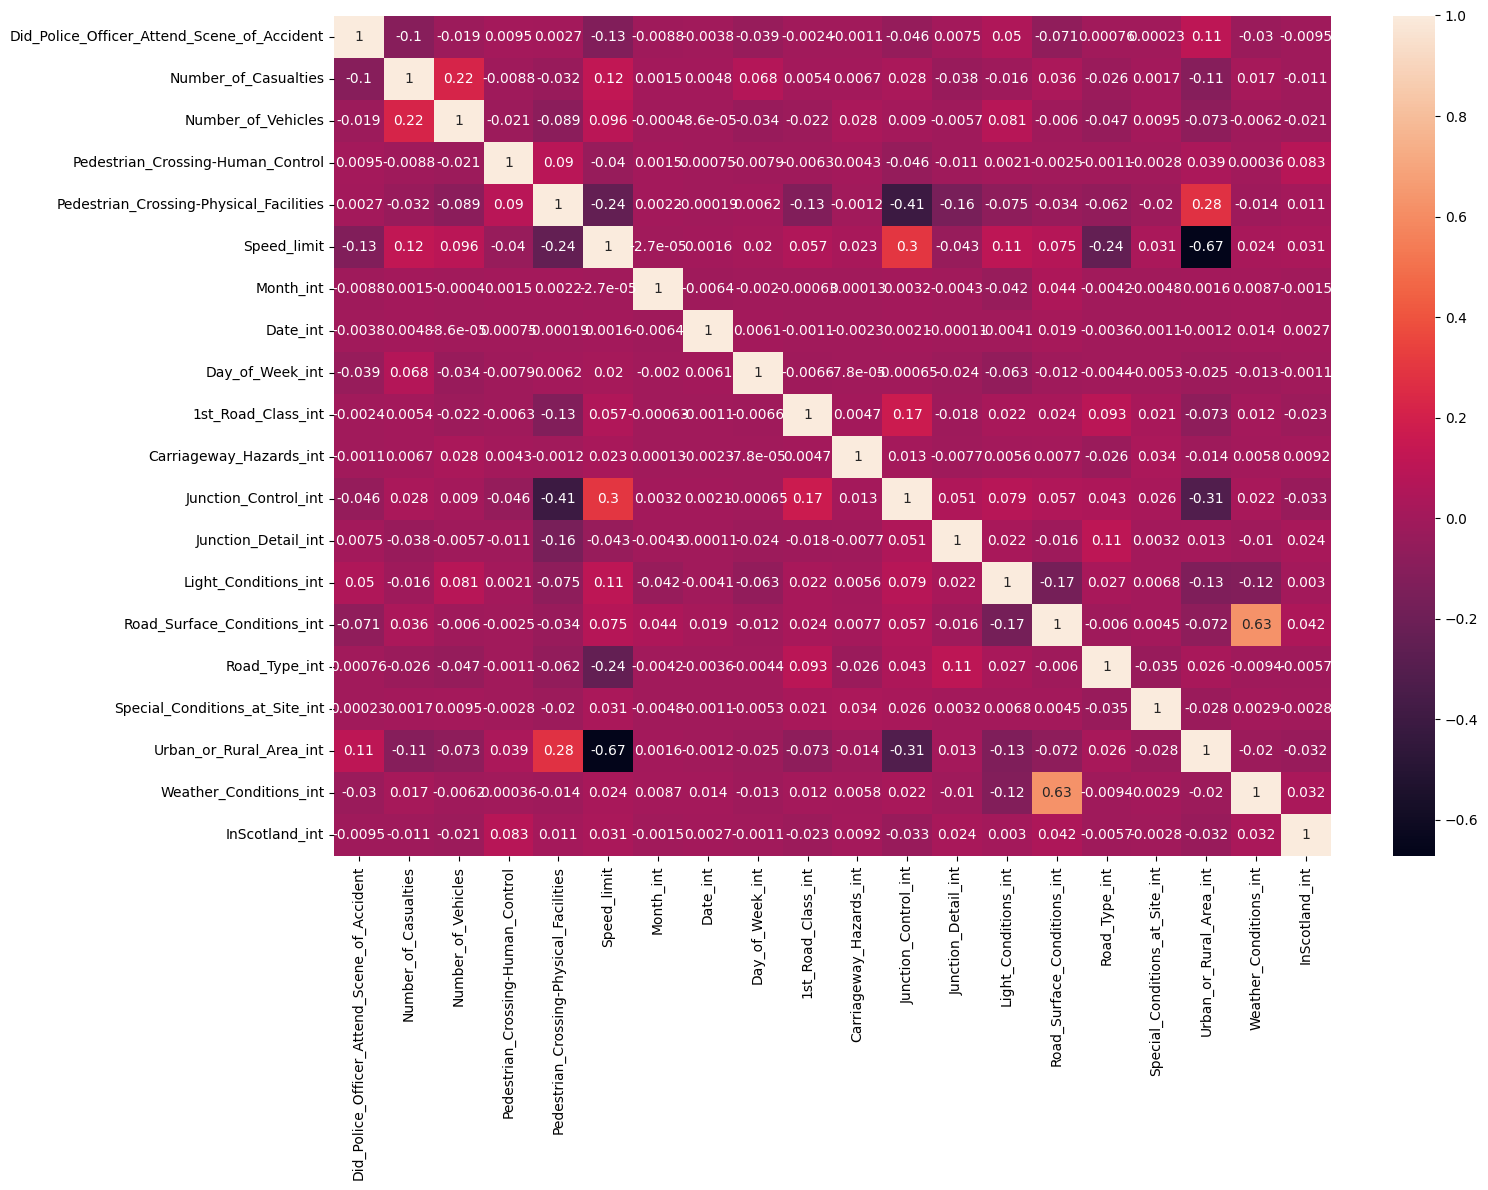

In [15]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(accident_data[training_cols].corr(), annot=True, ax=ax)
plt.show()

In [16]:
X = accident_data[training_cols]
Y = accident_data['Accident_Severity']
sm = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4
)

X_sm, Y_sm = sm.fit_resample(X, Y)

print(accident_data['Accident_Severity'].unique())

X_train, X_test, Y_train, Y_test=train_test_split(X_sm, Y_sm,test_size=0.2,random_state=40)

[0 1 2]


In [17]:
# Performing Feature Scaling to the training and testing input data 
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


In [18]:
#Initializing the ANN layer 
ann_model=Sequential()
# Adding the first layer with the input dimension equivalent to number of training columns
ann_model.add(Dense(input_shape=(X.shape[1],),units=8,activation='relu'))
# Adding the Hidden Layer below the input layer
ann_model.add(Dense(units=16,activation='relu'))
# Adding the output layer
ann_model.add(Dense(units=3,activation='softmax'))

In [19]:
ann_model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...



In [ ]:
# now we just update our model fit call
ann_model.fit(X_train_scaled, Y_train, batch_size= 20, epochs=1000, callbacks=[es])
#print(X_train.values.shape)

Epoch 1/1000
32020/49709 [==================>...........] - ETA: 24s - loss: 0.9132 - accuracy: 0.5516

In [ ]:
preds = ann_model.predict(X_test_scaled)
Y_pred= preds.argmax(axis=1)

In [ ]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Y_test, Y_pred))
print('Balanced accuracy, Random Forest test:', balanced_accuracy_score(Y_test, Y_pred))
print('Recall Score', recall_score(Y_test, Y_pred , average=None))

In [ ]:
confusion_matrix(Y_test, Y_pred)

In [ ]:
print(classification_report(Y_test, Y_pred))